In [79]:
import numpy as np
from numpy.linalg import cholesky, solve
import matplotlib.pyplot as plt
from math import erf

In [80]:
#define consts 
N = 20
coords_1d = np.linspace(0, 1, N)
X_grid = np.array([(x, y) for x in coords_1d for y in coords_1d])  # (N^2, 2)
n_points = X_grid.shape[0]

g_cut = 0.0
v_val = 1.0
c_d = 0.05
sigma_noise = 0.05


In [81]:
#generate ground truth... 
import numpy as np

# kernel using gaussian 
def gaussian(X1, X2, length=0.25, variance=1.0):
    # squared distances
    X1_sq = np.sum(X1**2, axis=1)[:, None]      # (n1, 1)
    X2_sq = np.sum(X2**2, axis=1)[None, :]      # (1, n2)
    dists = X1_sq + X2_sq - 2 * (X1 @ X2.T)     # (n1, n2)
    K = variance * np.exp(-0.5 * dists / (length**2))
    return K
    #k =[n1, n2] w covariance K_ij = var * exp(-0.5 * || x_i - x_j || ^ 2 / length^2)

#generate ground truth, we sample one true ore from the GP prior over thr grid and return an array of grades
def sample_ground_truth(X_grid, length=0.25, variance=1.0, jitter=1e-6):
    n = X_grid.shape[0]
    K_full = gaussian(X_grid, X_grid, length=length, variance=variance)
    # numerical jitter on the diagonal
    K_full = K_full + jitter * np.eye(n)
    # Cholesky factorization: K = L L^T
    L = np.linalg.cholesky(K_full)
    # sample z ~ N(0, I)
    z = np.random.randn(n)
    # correlated sample: G_true ~ N(0, K)
    G_true = L @ z
    return G_true

G_true = sample_ground_truth(X_grid, length=0.25, variance=1.0)
G_true_grid = G_true.reshape(N, N)  # for plotting later
print("Ground truth field shape:", G_true_grid.shape)
#Initialize prior over grades 
#before drilling every cell has grade 0 , correlations encoded in covariance matrix 
# mu = np.zeros(n_points)
# Sigma = K_full

Ground truth field shape: (20, 20)


In [82]:
#single drilling observation + gaussian posterior update given the data we observe

#Kalman filter esque, update given one new noisy observation at index i across nxn, should probably maybe ij
def update_posterior(mu, Sigma, i, y_i, sigma2):
    #sigma2 is noise variance, yi is observed grade, mu / sigma are current mean / covariance, i = cell index
    # predictive mean and variance of this observation under the current belief
    y_hat = mu[i]                 # E[y_i | current belief]
    S = Sigma[i, i] + sigma2      # Var[y_i | current belief]
    # how surprising was the observation
    e = y_i - y_hat               # if e ~ 0 no surprise, if big, we adjust more
    g = Sigma[:, i] / S         
    # shift each cell proportional to gain * surprise, updated mean
    mu_new = mu + g * e       
    # updated covariance 
    Sigma_new = Sigma - np.outer(g, g) * S   # (n_points, n_points)

    return mu_new, Sigma_new



In [83]:
#posterior sampling, sample one full ore field from the current posterior, thompson sampling? not yet implemented
def sample_posterior(mu, Sigma, jitter=1e-6):
    n = mu.shape[0]
    # numerical jitter to make Sigma positive definite
    Sigma_j = Sigma + jitter * np.eye(n)
    L = np.linalg.cholesky(Sigma_j)
    z = np.random.randn(n)
    return mu + L @ z


In [84]:
#main 
N = 40
coords_1d = np.linspace(0.0, 1.0, N)
X_grid = np.array([(x, y) for x in coords_1d for y in coords_1d])
n_points = X_grid.shape[0]
K_full = gaussian(X_grid, X_grid, length=0.1, variance=1.0)

# sample from the hidden body
G_true = sample_ground_truth(X_grid, length=0.1, variance=1.0)
mu = np.zeros(n_points)  #0 
Sigma = K_full.copy()     #spatial correlation, gaussian normal 

sigma_obs = 0.05     
sigma2_obs = sigma_obs**2
B = 10                    # drill no.

drilled_indices = []

for t in range(B):
    # pick a random cell
    candidates = np.setdiff1d(np.arange(n_points), np.array(drilled_indices, dtype=int))
    i = np.random.choice(candidates)
    drilled_indices.append(i)
    # observe noisy output ore grade at that cell from the hidden true field
    y_i = G_true[i] + sigma_obs * np.random.randn()
    # update posterior belief
    mu, Sigma = update_posterior(mu, Sigma, i, y_i, sigma2_obs)
    print(f"Step {t+1}: drilled cell {i}, observed y_i={y_i:.3f}")

# After B drills, mu and Sigma are your posterior belief over the whole grid
print("Posterior mean shape:", mu.shape)
print("Posterior covariance shape:", Sigma.shape)


Step 1: drilled cell 1414, observed y_i=1.083
Step 2: drilled cell 979, observed y_i=-2.088
Step 3: drilled cell 755, observed y_i=0.764
Step 4: drilled cell 809, observed y_i=-0.056
Step 5: drilled cell 321, observed y_i=0.619
Step 6: drilled cell 936, observed y_i=-2.797
Step 7: drilled cell 499, observed y_i=-1.292
Step 8: drilled cell 182, observed y_i=0.415
Step 9: drilled cell 1222, observed y_i=-0.692
Step 10: drilled cell 983, observed y_i=0.495
Posterior mean shape: (1600,)
Posterior covariance shape: (1600, 1600)


<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
/var/folders/hk/tjpsmfl909l0931nl3zhpscm0000gn/T/ipykernel_59307/2256808665.py:19: SyntaxWarning: invalid escape sequence '\m'
  axes[1].set_title("Posterior mean $\mu$")


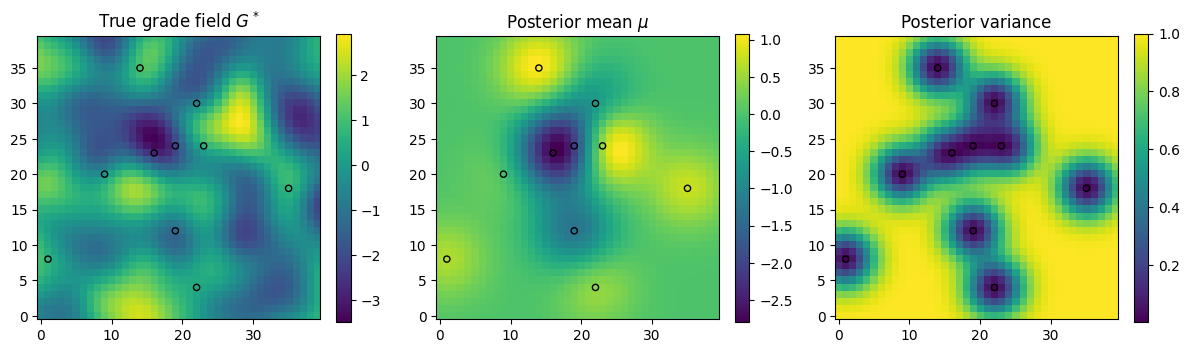

In [85]:
#plot grid so we can see... 

G_true_grid = G_true.reshape(N, N)
mu_grid = mu.reshape(N, N)
var_grid = np.diag(Sigma).reshape(N, N)

# coordinates of drilled cells (for scatter)
drilled_coords = np.array([divmod(i, N) for i in drilled_indices])  # (row, col) pairs

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# panel 1: hidden true ore body
im0 = axes[0].imshow(G_true_grid, origin="lower")
axes[0].set_title("True grade field $G^*$")
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# panel 2: posterior mean after drilling
im1 = axes[1].imshow(mu_grid, origin="lower")
axes[1].set_title("Posterior mean $\mu$")
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# panel 3: posterior variance
im2 = axes[2].imshow(var_grid, origin="lower")
axes[2].set_title("Posterior variance")
plt.colorbar(im2, ax=axes[2], fraction=0.046)

# overlay drill locations on each panel
for ax in axes:
    if len(drilled_coords) > 0:
        ax.scatter(drilled_coords[:,1], drilled_coords[:,0],
                   s=20, edgecolor="k", facecolor="none")  # (col, row)

plt.tight_layout()
plt.show()


<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
/var/folders/hk/tjpsmfl909l0931nl3zhpscm0000gn/T/ipykernel_59307/1329301826.py:11: SyntaxWarning: invalid escape sequence '\m'
  axes[1].set_title("Predicted ore from $\mu$")


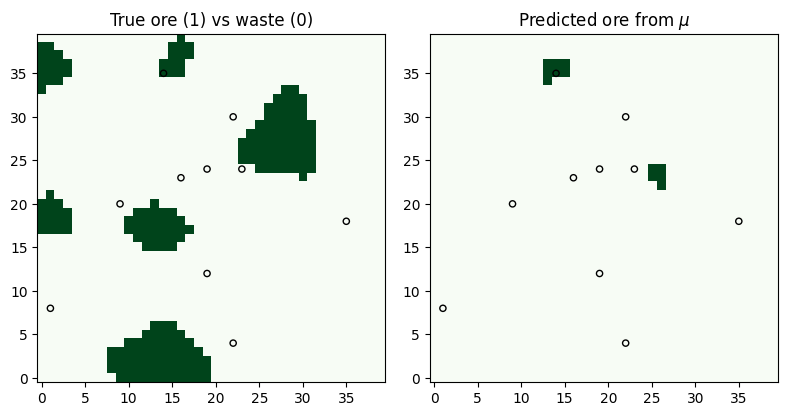

In [86]:
#what do we think is ore vs is not? 
g_cut = 1.0

true_ore_mask = (G_true >= g_cut).reshape(N, N)
pred_ore_mask = (mu >= g_cut).reshape(N, N)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(true_ore_mask, origin="lower", cmap="Greens")
axes[0].set_title("True ore (1) vs waste (0)")
axes[1].imshow(pred_ore_mask, origin="lower", cmap="Greens")
axes[1].set_title("Predicted ore from $\mu$")

for ax in axes:
    if len(drilled_coords) > 0:
        ax.scatter(drilled_coords[:,1], drilled_coords[:,0],
                   s=20, edgecolor="k", facecolor="none")

plt.tight_layout()
plt.show()


=== High-grade drill ===
Drilling at index 1108, true grade=2.915, observed y_i=2.912


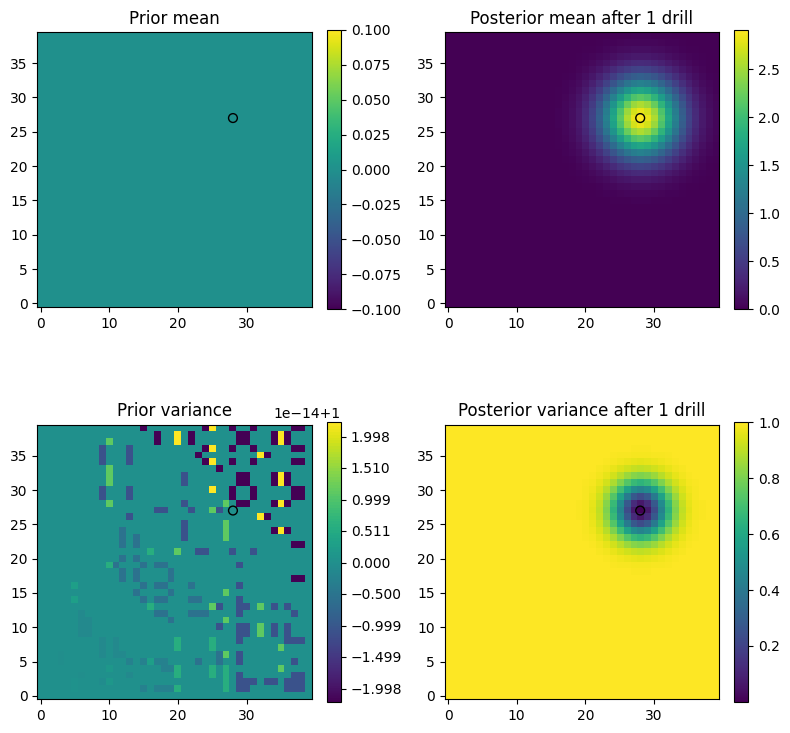

=== Low-grade drill ===
Drilling at index 1016, true grade=-3.485, observed y_i=-3.495


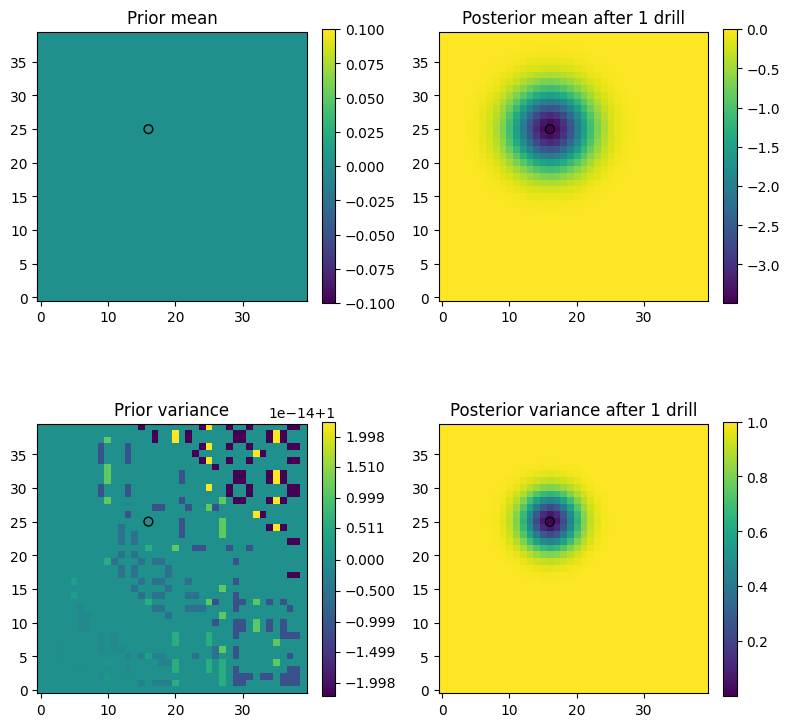

In [87]:
def plot_single_drill_effect(i, sigma_obs=0.05):
    sigma2_obs = sigma_obs**2

    # start from prior
    mu0 = np.zeros(n_points)
    Sigma0 = K_full.copy()          # same kernel as your prior
    mu = mu0.copy()
    Sigma = Sigma0.copy() 

    # observe at i from the hidden true field
    y_i = G_true[i] + sigma_obs * np.random.randn()
    print(f"Drilling at index {i}, true grade={G_true[i]:.3f}, observed y_i={y_i:.3f}")

    # update posterior
    mu1, Sigma1 = update_posterior(mu, Sigma, i, y_i, sigma2_obs)

    # reshape for plotting
    mu0_grid = mu0.reshape(N, N)
    mu1_grid = mu1.reshape(N, N)
    var0_grid = np.diag(Sigma0).reshape(N, N)
    var1_grid = np.diag(Sigma1).reshape(N, N)

    r, c = divmod(i, N)  # row, col of drill

    fig, axes = plt.subplots(2, 2, figsize=(8, 8))

    im00 = axes[0,0].imshow(mu0_grid, origin="lower")
    axes[0,0].set_title("Prior mean")
    axes[0,0].scatter([c], [r], s=40, edgecolor="k", facecolor="none")
    plt.colorbar(im00, ax=axes[0,0], fraction=0.046)

    im01 = axes[0,1].imshow(mu1_grid, origin="lower")
    axes[0,1].set_title("Posterior mean after 1 drill")
    axes[0,1].scatter([c], [r], s=40, edgecolor="k", facecolor="none")
    plt.colorbar(im01, ax=axes[0,1], fraction=0.046)

    im10 = axes[1,0].imshow(var0_grid, origin="lower")
    axes[1,0].set_title("Prior variance")
    axes[1,0].scatter([c], [r], s=40, edgecolor="k", facecolor="none")
    plt.colorbar(im10, ax=axes[1,0], fraction=0.046)

    im11 = axes[1,1].imshow(var1_grid, origin="lower")
    axes[1,1].set_title("Posterior variance after 1 drill")
    axes[1,1].scatter([c], [r], s=40, edgecolor="k", facecolor="none")
    plt.colorbar(im11, ax=axes[1,1], fraction=0.046)

    plt.tight_layout()
    plt.show()

# pick a high-grade cell
i_high = int(np.argmax(G_true))
# pick a low-grade cell
i_low  = int(np.argmin(G_true))

print("=== High-grade drill ===")
plot_single_drill_effect(i_high, sigma_obs=0.01)   # almost noiseless, very clean update

print("=== Low-grade drill ===")
plot_single_drill_effect(i_low, sigma_obs=0.01)


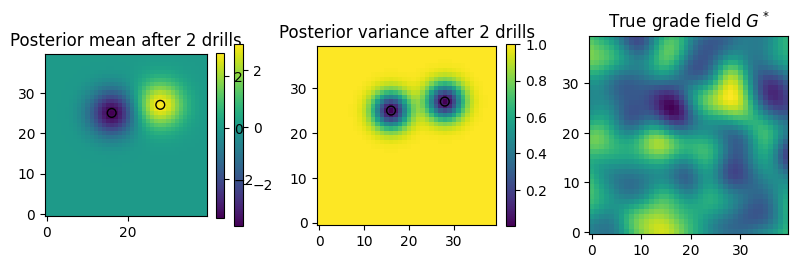

In [88]:
def plot_two_drills_effect(i1, i2, sigma_obs=0.01):
    sigma2_obs = sigma_obs**2

    mu = np.zeros(n_points)
    Sigma = K_full.copy()

    # first drill
    y1 = G_true[i1] + sigma_obs * np.random.randn()
    mu, Sigma = update_posterior(mu, Sigma, i1, y1, sigma2_obs)

    # second drill
    y2 = G_true[i2] + sigma_obs * np.random.randn()
    mu, Sigma = update_posterior(mu, Sigma, i2, y2, sigma2_obs)

    mu_grid = mu.reshape(N, N)
    var_grid = np.diag(Sigma).reshape(N, N)

    r1, c1 = divmod(i1, N)
    r2, c2 = divmod(i2, N)

    fig, axes = plt.subplots(1, 3, figsize=(8, 4))

    im0 = axes[0].imshow(mu_grid, origin="lower")
    axes[0].set_title("Posterior mean after 2 drills")
    axes[0].scatter([c1, c2], [r1, r2], s=40, edgecolor="k", facecolor="none")
    plt.colorbar(im0, ax=axes[0], fraction=0.046)

    im1 = axes[1].imshow(var_grid, origin="lower")
    axes[1].set_title("Posterior variance after 2 drills")
    axes[1].scatter([c1, c2], [r1, r2], s=40, edgecolor="k", facecolor="none")
    plt.colorbar(im1, ax=axes[1], fraction=0.046)

    im2 = axes[2].imshow(G_true_grid, origin="lower")
    axes[2].set_title("True grade field $G^*$")
    plt.colorbar(im2, ax=axes[0], fraction=0.046)

    plt.tight_layout()
    plt.show()

plot_two_drills_effect(i_high, i_low, sigma_obs=0.01)



In [89]:
def rmse(mu, G_true):
    return np.sqrt(np.mean((mu - G_true)**2))

def run_drilling_experiment(G_true, K_full, B=4, sigma_obs=0.05,
                            policy="random", beta=2.0, verbose=False):
    n_points = len(G_true)
    mu = np.zeros(n_points) 
    Sigma = K_full.copy()  
    sigma2 = sigma_obs**2

    drilled_indices = []

    for t in range(B):
        candidates = np.setdiff1d(np.arange(n_points),
                                  np.array(drilled_indices, dtype=int))
        if policy == "random":
            i = np.random.choice(candidates)
        elif policy == "ucb":
            # GP-UCB: mu + sqrt(beta) * sigma
            mu_cand = mu[candidates]
            var_cand = np.diag(Sigma)[candidates]
            ucb_scores = mu_cand + np.sqrt(beta) * np.sqrt(var_cand)
            i = candidates[np.argmax(ucb_scores)]
        drilled_indices.append(i)
        # observe noisy grade from hidden field
        y_i = G_true[i] + sigma_obs * np.random.randn()
        # update posterior
        mu, Sigma = update_posterior(mu, Sigma, i, y_i, sigma2)
        if verbose:
            print(f"[{policy}] step {t+1}: drilled {i}, y_i={y_i:.3f}")
    # quantify how well we learned the ore body
    final_rmse = rmse(mu, G_true)

    return final_rmse, mu, Sigma, drilled_indices

N = 40
coords_1d = np.linspace(0.0, 1.0, N)
X_grid = np.array([(x, y) for x in coords_1d for y in coords_1d])
n_points = X_grid.shape[0]

K_full = gaussian(X_grid, X_grid, length=0.15, variance=1.0)
G_true = sample_ground_truth(X_grid, length=0.15, variance=1.0)

# --- run policies on the SAME hidden world ---

B = 5         # only 4 drillholes
sigma_obs = 0.05
beta = 3.0

rmse_rand, mu_rand, Sigma_rand, drilled_rand = run_drilling_experiment(
    G_true, K_full, B=B, sigma_obs=sigma_obs, policy="random", beta=beta)

rmse_ucb, mu_ucb, Sigma_ucb, drilled_ucb = run_drilling_experiment(
    G_true, K_full, B=B, sigma_obs=sigma_obs, policy="ucb", beta=beta)

print(f"Random policy RMSE after {B} drills: {rmse_rand:.3f}")
print(f"UCB policy RMSE    after {B} drills: {rmse_ucb:.3f}")


Random policy RMSE after 5 drills: 0.754
UCB policy RMSE    after 5 drills: 0.747


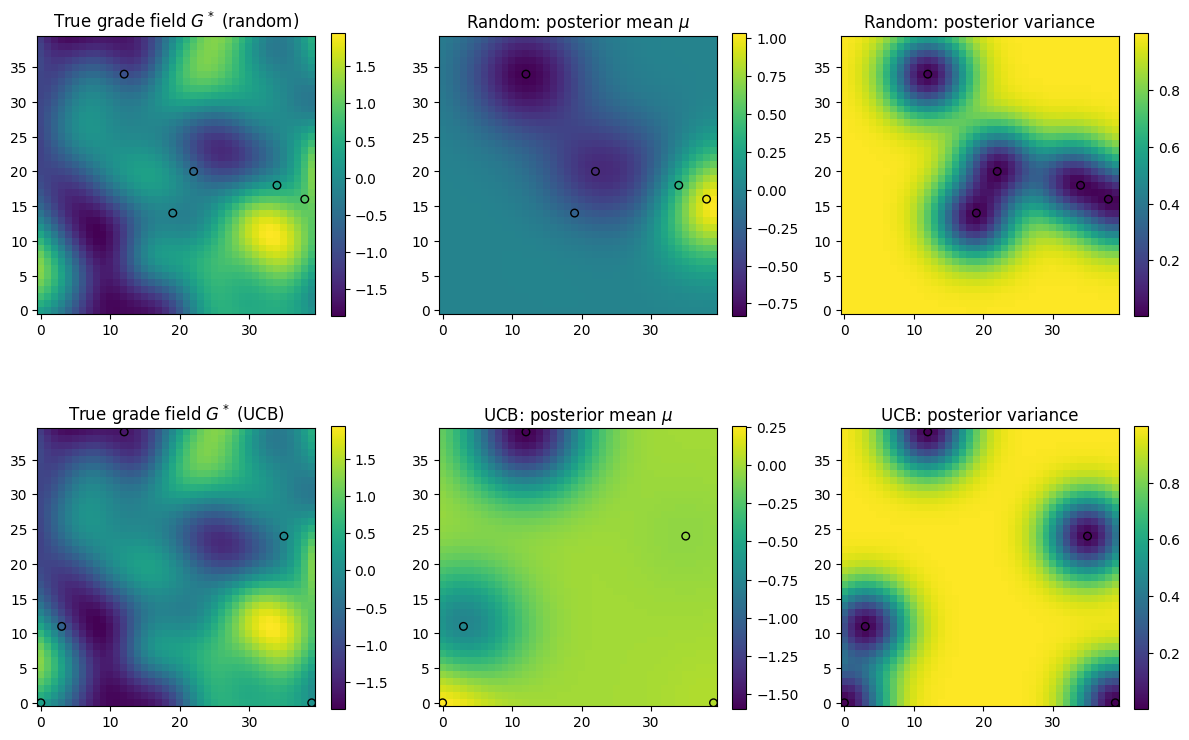

RMSE random: 0.7538091917715615
RMSE UCB   : 0.7472407360413923


In [90]:
#plot grid so we can see... UCB VS RANDOM DRILLING POLICY

def plot_random_vs_ucb(G_true, 
                       mu_rand, Sigma_rand, drilled_rand,
                       mu_ucb,  Sigma_ucb,  drilled_ucb,
                       N):

    G_true_grid = G_true.reshape(N, N)

    # grids for each policy
    mu_rand_grid  = mu_rand.reshape(N, N)
    var_rand_grid = np.diag(Sigma_rand).reshape(N, N)

    mu_ucb_grid   = mu_ucb.reshape(N, N)
    var_ucb_grid  = np.diag(Sigma_ucb).reshape(N, N)

    # (row, col) coords of drilled cells
    drilled_rand_coords = np.array([divmod(i, N) for i in drilled_rand])
    drilled_ucb_coords  = np.array([divmod(i, N) for i in drilled_ucb])

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # ---------- ROW 0: RANDOM POLICY ----------
    # True field
    im00 = axes[0,0].imshow(G_true_grid, origin="lower")
    axes[0,0].set_title("True grade field $G^*$ (random)")
    plt.colorbar(im00, ax=axes[0,0], fraction=0.046)

    # Posterior mean
    im01 = axes[0,1].imshow(mu_rand_grid, origin="lower")
    axes[0,1].set_title(r"Random: posterior mean $\mu$")
    plt.colorbar(im01, ax=axes[0,1], fraction=0.046)

    # Posterior variance
    im02 = axes[0,2].imshow(var_rand_grid, origin="lower")
    axes[0,2].set_title("Random: posterior variance")
    plt.colorbar(im02, ax=axes[0,2], fraction=0.046)

    # overlay drill locations (random)
    if len(drilled_rand_coords) > 0:
        for ax in axes[0,:]:
            ax.scatter(drilled_rand_coords[:,1], drilled_rand_coords[:,0],
                       s=30, edgecolor="k", facecolor="none")

    # ---------- ROW 1: UCB POLICY ----------
    # True field (same, but keep for visual comparison)
    im10 = axes[1,0].imshow(G_true_grid, origin="lower")
    axes[1,0].set_title("True grade field $G^*$ (UCB)")
    plt.colorbar(im10, ax=axes[1,0], fraction=0.046)

    # Posterior mean
    im11 = axes[1,1].imshow(mu_ucb_grid, origin="lower")
    axes[1,1].set_title(r"UCB: posterior mean $\mu$")
    plt.colorbar(im11, ax=axes[1,1], fraction=0.046)

    # Posterior variance
    im12 = axes[1,2].imshow(var_ucb_grid, origin="lower")
    axes[1,2].set_title("UCB: posterior variance")
    plt.colorbar(im12, ax=axes[1,2], fraction=0.046)

    # overlay drill locations (UCB)
    if len(drilled_ucb_coords) > 0:
        for ax in axes[1,:]:
            ax.scatter(drilled_ucb_coords[:,1], drilled_ucb_coords[:,0],
                       s=30, edgecolor="k", facecolor="none")

    plt.tight_layout()
    plt.show()

plot_random_vs_ucb(G_true,
                   mu_rand, Sigma_rand, drilled_rand,
                   mu_ucb,  Sigma_ucb,  drilled_ucb,
                   N)
print("RMSE random:", rmse_rand)
print("RMSE UCB   :", rmse_ucb)


In [91]:

N = 40
coords_1d = np.linspace(0.0, 1.0, N)
X_grid = np.array([(x, y) for x in coords_1d for y in coords_1d])
n_points = X_grid.shape[0]

K_full = gaussian(X_grid, X_grid, length=0.15, variance=1.0)

B = 6            
sigma_obs = 0.05
#exploration
beta = 2.0 
n_trials = 50

rmse_rand_list = []
rmse_ucb_list  = []

for trial in range(n_trials):
    # sample a new hidden ore body
    G_true = sample_ground_truth(X_grid, length=0.15, variance=1.0)

    # run both policies on the SAME G_true
    rmse_rand, _, _, _ = run_drilling_experiment(
        G_true, K_full, B=B, sigma_obs=sigma_obs,
        policy="random", beta=beta)

    rmse_ucb, _, _, _ = run_drilling_experiment(
        G_true, K_full, B=B, sigma_obs=sigma_obs,
        policy="ucb", beta=beta)

    rmse_rand_list.append(rmse_rand)
    rmse_ucb_list.append(rmse_ucb)

rmse_rand_arr = np.array(rmse_rand_list)
rmse_ucb_arr  = np.array(rmse_ucb_list)

print(f"Random  mean RMSE: {rmse_rand_arr.mean():.3f} ± {rmse_rand_arr.std():.3f}")
print(f"UCB     mean RMSE: {rmse_ucb_arr.mean():.3f} ± {rmse_ucb_arr.std():.3f}")
print(f"Mean RMSE reduction (UCB - Random): {(rmse_ucb_arr.mean()-rmse_rand_arr.mean()):.3f}")


Random  mean RMSE: 0.854 ± 0.147
UCB     mean RMSE: 0.918 ± 0.161
Mean RMSE reduction (UCB - Random): 0.064


In [92]:
def run_drilling_experiment(G_true, K_full, B=4, sigma_obs=0.05,
                            policy="random", beta=2.0, eps=0.1,
                            g_cut=1.0, voi_k=50, voi_mc=5, 
                            lambda_cost=0.0,  
                            verbose=False):
    n_points = len(G_true)
    mu = np.zeros(n_points)
    Sigma = K_full.copy()
    sigma2 = sigma_obs**2

    drilled_indices = []

    for t in range(B):
        candidates = np.setdiff1d(np.arange(n_points),
                                  np.array(drilled_indices, dtype=int))

        if policy == "random":
            i = np.random.choice(candidates)

        elif policy == "ucb":
            mu_cand = mu[candidates]
            var_cand = np.diag(Sigma)[candidates]
            ucb_scores = mu_cand + np.sqrt(beta) * np.sqrt(var_cand)
            i = candidates[np.argmax(ucb_scores)]

        elif policy == "thompson":
            # sample one function from posterior
            G_sample = sample_posterior(mu, Sigma)
            # pick best undrilled location under that sampled function
            i = candidates[np.argmax(G_sample[candidates])]

        elif policy == "eps_greedy":
            if np.random.rand() < eps:
                # explore
                i = np.random.choice(candidates)
            else:
                # exploit: highest posterior mean
                mu_cand = mu[candidates]
                i = candidates[np.argmax(mu_cand)]

        elif policy == "straddle":
            # --- straddle / contour-learning policy ---
            mu_cand   = mu[candidates]
            var_cand  = np.diag(Sigma)[candidates]
            sigma_cand = np.sqrt(np.maximum(var_cand, 1e-12))  # avoid div by 0

            # z = (g_cut - mu) / sigma
            z = (g_cut - mu_cand) / sigma_cand

            # standard normal CDF Phi(z) using erf
            # Phi(z) = 0.5 * (1 + erf(z / sqrt(2)))
            # P(ore) = 1 - Phi(z)
            phi = 0.5 * (1.0 + np.vectorize(erf)(z / np.sqrt(2.0)))
            p_ore = 1.0 - phi

            # misclassification probability: min(p_ore, 1 - p_ore)
            misclass = np.minimum(p_ore, 1.0 - p_ore)

            # optionally, could multiply by sigma_cand to prefer high-variance points:
            # misclass *= sigma_cand

            i = candidates[np.argmax(misclass)]

        elif policy == "voi_mask":
            # ---- VOI on ore mask: expected reduction in ore-mask risk ----

            # 1) Pre-filter to top-K boundary-ish candidates
            top_cands = top_boundary_candidates(mu, Sigma, g_cut,
                                                candidates, k=voi_k)

            # 2) For each candidate, approximate expected ore-mask risk after drilling
            best_i = None
            best_expected_risk = None

            for c in top_cands:
                exp_risk_c = expected_ore_risk_after_drill(
                    c, mu, Sigma, sigma_obs, g_cut, n_mc=voi_mc
                )
                if (best_expected_risk is None) or (exp_risk_c < best_expected_risk):
                    best_expected_risk = exp_risk_c
                    best_i = c

            i = best_i

        elif policy == "voi_rmse":
            # ---- VOI on RMSE: pick drill that maximizes reduction in total variance ----
            best_i = None
            best_reduction = -np.inf

            for c in candidates:
                col = Sigma[:, c]                       # column c
                S_loc = Sigma[c, c] + sigma2           # predictive variance at c (incl. noise)
                num = np.dot(col, col)                 # ||Sigma[:, c]||^2
                reduction_c = num / max(S_loc, 1e-12)  # avoid div by zero

                if reduction_c > best_reduction:
                    best_reduction = reduction_c
                    best_i = c

            i = best_i
        elif policy == "voi_rmse_cost":
            # ---- Cost-aware VOI on RMSE ----
            # We will maximize: reduction_c - lambda_cost * distance_to_last_drill
            last_drill = drilled_indices[-1] if drilled_indices else None

            best_i = None
            best_score = -np.inf

            for c in candidates:
                col = Sigma[:, c]
                S_loc = Sigma[c, c] + sigma2
                num = np.dot(col, col)
                reduction_c = num / max(S_loc, 1e-12)

                # movement cost
                move_cost = lambda_cost * drill_distance(c, last_drill, n_points)

                net_score = reduction_c - move_cost

                if net_score > best_score:
                    best_score = net_score
                    best_i = c

            i = best_i
        else:
            raise ValueError(f"Unknown policy: {policy}")

        drilled_indices.append(i)

        # observe noisy grade from ground truth
        y_i = G_true[i] + sigma_obs * np.random.randn()

        # Bayesian update
        mu, Sigma = update_posterior(mu, Sigma, i, y_i, sigma2)

        if verbose:
            print(f"[{policy}] step {t+1}: drilled {i}, y_i={y_i:.3f}")

    final_rmse = np.sqrt(np.mean((mu - G_true)**2))
    return final_rmse, mu, Sigma, drilled_indices



In [93]:
def compute_npv(mu, G_true, drilled_indices, 
                g_cut_mine=1.0,
                price_per_unit=1.0,
                cost_mine_per_cell=0.1,
                cost_drill_per_hole=0.05):
    """
    Compute NPV of a mining plan based on the posterior mean mu.

    - mu: posterior mean grades (length n_points)
    - G_true: true hidden grades (same shape)
    - drilled_indices: list of indices drilled (len = B)
    - g_cut_mine: economic cut-off grade used to decide what to mine
    - price_per_unit: value per unit grade above cut-off
    - cost_mine_per_cell: cost to mine one cell
    - cost_drill_per_hole: cost per drillhole

    Returns: scalar NPV
    """

    mu = np.asarray(mu)
    G_true = np.asarray(G_true)

    # 1) Decide which cells to mine based on posterior mean
    mined_mask = (mu >= g_cut_mine)
    mined_indices = np.where(mined_mask)[0]

    # 2) Revenue: only grade above cut-off counts, and only for mined cells
    #    revenue_i = price_per_unit * max(G_true[i] - g_cut_mine, 0)
    if len(mined_indices) > 0:
        true_grades_mined = G_true[mined_indices]
        grade_above_cut = np.maximum(true_grades_mined - g_cut_mine, 0.0)
        total_revenue = price_per_unit * np.sum(grade_above_cut)
    else:
        total_revenue = 0.0

    # 3) Mining costs: fixed cost per mined cell
    total_mining_cost = cost_mine_per_cell * len(mined_indices)

    # 4) Drilling costs: fixed cost per drill
    B = len(drilled_indices)
    total_drill_cost = cost_drill_per_hole * B

    # 5) NPV = revenue - costs
    npv = total_revenue - total_mining_cost - total_drill_cost
    return npv


In [94]:
#final comparison scripts... 

N = 40
coords_1d = np.linspace(0.0, 1.0, N)
X_grid = np.array([(x, y) for x in coords_1d for y in coords_1d])  # shape (n_points, 2)
n_points = X_grid.shape[0]

K_full = gaussian(X_grid, X_grid, length=0.15, variance=1.0)
B = 5     
B = 5     
sigma_obs = 0.05
beta = 2.5
eps = 0.1
lambda_cost = 0.2 # 0 = ignore cost; larger = more localized drilling
g_cut_mine = 1.0
price_per_unit = 1.0
cost_mine_per_cell = 0.1
cost_drill_per_hole = 0.05

rmse_rand, mu_rand, Sigma_rand, drilled_rand = run_drilling_experiment(
    G_true, K_full, B=B, sigma_obs=sigma_obs,
    policy="random", beta=beta, eps=eps)

rmse_ucb,  mu_ucb,  Sigma_ucb,  drilled_ucb = run_drilling_experiment(
    G_true, K_full, B=B, sigma_obs=sigma_obs,
    policy="ucb", beta=beta, eps=eps)

rmse_ts,   mu_ts,   Sigma_ts,   drilled_ts = run_drilling_experiment(
    G_true, K_full, B=B, sigma_obs=sigma_obs,
    policy="thompson", beta=beta, eps=eps)

rmse_eps,  mu_eps,  Sigma_eps,  drilled_eps = run_drilling_experiment(
    G_true, K_full, B=B, sigma_obs=sigma_obs,
    policy="eps_greedy", beta=beta, eps=eps)

rmse_straddle, mu_straddle, Sigma_straddle, drilled_straddle = run_drilling_experiment(
    G_true, K_full, B=B, sigma_obs=sigma_obs,
    policy="straddle", g_cut=1.0)

rmse_voi, mu_voi, Sigma_voi, drilled_voi = run_drilling_experiment(
    G_true, K_full, B=B, sigma_obs=sigma_obs,
    policy="voi_mask", g_cut=1.0, voi_k=50, voi_mc=5
)

rmse_voi_rmse, mu_voi_rmse, Sigma_voi_rmse, drilled_voi_rmse = run_drilling_experiment(
    G_true, K_full, B=B, sigma_obs=sigma_obs,
    policy="voi_rmse"
)

rmse_voi_rmse_cost, mu_voi_rmse_cost, Sigma_voi_rmse_cost, drilled_voi_rmse_cost = run_drilling_experiment(
    G_true, K_full, B=B, sigma_obs=sigma_obs,
    policy="voi_rmse_cost", lambda_cost=lambda_cost
)



npv_rand = compute_npv(mu_rand, G_true, drilled_rand,
                       g_cut_mine=g_cut_mine,
                       price_per_unit=price_per_unit,
                       cost_mine_per_cell=cost_mine_per_cell,
                       cost_drill_per_hole=cost_drill_per_hole)

npv_ucb = compute_npv(mu_ucb, G_true, drilled_ucb,
                      g_cut_mine=g_cut_mine,
                      price_per_unit=price_per_unit,
                      cost_mine_per_cell=cost_mine_per_cell,
                      cost_drill_per_hole=cost_drill_per_hole)

npv_ts = compute_npv(mu_ts, G_true, drilled_ts,
                      g_cut_mine=g_cut_mine,
                      price_per_unit=price_per_unit,
                      cost_mine_per_cell=cost_mine_per_cell,
                      cost_drill_per_hole=cost_drill_per_hole)

npv_eps = compute_npv(mu_eps, G_true, drilled_eps,
                      g_cut_mine=g_cut_mine,
                      price_per_unit=price_per_unit,
                      cost_mine_per_cell=cost_mine_per_cell,
                      cost_drill_per_hole=cost_drill_per_hole)

npv_straddle = compute_npv(mu_straddle, G_true, drilled_straddle,
                      g_cut_mine=g_cut_mine,
                      price_per_unit=price_per_unit,
                      cost_mine_per_cell=cost_mine_per_cell,
                      cost_drill_per_hole=cost_drill_per_hole)

npv_voi = compute_npv(mu_voi, G_true, drilled_voi,
                      g_cut_mine=g_cut_mine,
                      price_per_unit=price_per_unit,
                      cost_mine_per_cell=cost_mine_per_cell,
                      cost_drill_per_hole=cost_drill_per_hole)

npv_voi_rmse = compute_npv(mu_voi_rmse, G_true, drilled_voi_rmse,
                      g_cut_mine=g_cut_mine,
                      price_per_unit=price_per_unit,
                      cost_mine_per_cell=cost_mine_per_cell,
                      cost_drill_per_hole=cost_drill_per_hole)

npv_voi_rmse_cost = compute_npv(mu_voi_rmse_cost, G_true, drilled_voi_rmse_cost,
                      g_cut_mine=g_cut_mine,
                      price_per_unit=price_per_unit,
                      cost_mine_per_cell=cost_mine_per_cell,
                      cost_drill_per_hole=cost_drill_per_hole)

print(f"Drill budget B = {B}")
print(f"Random    RMSE: {rmse_rand:.3f}")
print(f"UCB       RMSE: {rmse_ucb:.3f}")
print(f"Thompson  RMSE: {rmse_ts:.3f}")
print(f"eps-greedy RMSE: {rmse_eps:.3f}")
print(f"straddle RMSE: {rmse_straddle:.3f}")
print(f"voi_mask RMSE: {rmse_voi:.3f}")
print(f"voi_rmse RMSE: {rmse_voi_rmse:.3f}")
print(f"voi_rmse_cost RMSE: {rmse_voi_rmse_cost:.3f}")

print(f"Random    NPV: {npv_rand:.3f}")
print(f"UCB       NPV: {npv_ucb:.3f}")
print(f"Thompson  NPV: {npv_ts:.3f}")
print(f"eps-greedy NPV: {npv_eps:.3f}")
print(f"straddle NPV: {npv_straddle:.3f}")
print(f"voi_mask NPV: {npv_voi:.3f}")
print(f"voi_rmse NPV: {npv_voi_rmse:.3f}")
print(f"voi_rmse_cost NPV: {npv_voi_rmse_cost:.3f}")

Drill budget B = 5
Random    RMSE: 1.099
UCB       RMSE: 1.251
Thompson  RMSE: 0.926
eps-greedy RMSE: 1.088
straddle RMSE: 1.148
voi_mask RMSE: 1.293
voi_rmse RMSE: 0.995
voi_rmse_cost RMSE: 1.001
Random    NPV: -0.250
UCB       NPV: 67.873
Thompson  NPV: -0.250
eps-greedy NPV: -0.250
straddle NPV: 72.450
voi_mask NPV: -0.250
voi_rmse NPV: -0.250
voi_rmse_cost NPV: -0.250


In [95]:
def drill_distance(i, j, n_points):
    """
    Distance between grid cells i and j in index space,
    using Euclidean distance on (row, col) coordinates.
    """
    if (i is None) or (j is None):
        return 0.0
    N_side = int(np.sqrt(n_points))
    r_i, c_i = divmod(i, N_side)
    r_j, c_j = divmod(j, N_side)
    # return abs(r_i - r_j) + abs(c_i - c_j) #Manhattan
    return np.hypot(r_i - r_j, c_i - c_j)   

In [96]:
# defining ore mask
def ore_mask(mu, g_cut):
    return (mu >= g_cut).astype(int)

def ore_mask_accuracy(mu, G_true, g_cut):
    true_mask = (G_true >= g_cut).astype(int)
    pred_mask = ore_mask(mu, g_cut)
    return (true_mask == pred_mask).mean()

In [97]:
def standard_normal_cdf(z):
    # Phi(z) using erf
    z = np.asarray(z)
    erf_vec = np.vectorize(erf)
    return 0.5 * (1.0 + erf_vec(z / np.sqrt(2.0)))

def ore_mask_risk(mu, Sigma, g_cut):
    """
    Approximate classification risk of the ore mask:
    average misclassification probability over all cells,
    under the current posterior (mu, Sigma).
    """
    var = np.diag(Sigma)
    sigma = np.sqrt(np.maximum(var, 1e-12))   # avoid div-by-zero

    z = (g_cut - mu) / sigma
    phi = standard_normal_cdf(z)             # Phi(z)
    p_ore = 1.0 - phi                        # P(G >= g_cut)

    misclass = np.minimum(p_ore, 1.0 - p_ore)
    # could use sum() instead of mean(), it just scales all risks equally
    return misclass.mean()

def expected_ore_risk_after_drill(i, mu, Sigma, sigma_obs, g_cut, n_mc=5):
    """
    Approximate the expected ore-mask risk if we drill at cell i,
    using Monte Carlo over the possible observed grades y_i.
    """
    sigma2 = sigma_obs**2
    m_i = mu[i]
    s2_i = Sigma[i, i] + sigma2
    s_i = np.sqrt(max(s2_i, 1e-12))

    risks = []
    for _ in range(n_mc):
        # sample a hypothetical observation at i
        y_i = m_i + s_i * np.random.randn()
        # do a *hypothetical* update
        mu_new, Sigma_new = update_posterior(mu, Sigma, i, y_i, sigma2)
        # compute ore-mask risk under the new belief
        r_new = ore_mask_risk(mu_new, Sigma_new, g_cut)
        risks.append(r_new)
    return np.mean(risks)


In [98]:
def top_boundary_candidates(mu, Sigma, g_cut, candidates, k=50):
    """
    Among 'candidates' indices, pick up to k that are most ambiguous
    (highest misclassification probability).
    """
    var_cand   = np.diag(Sigma)[candidates]
    sigma_cand = np.sqrt(np.maximum(var_cand, 1e-12))
    mu_cand    = mu[candidates]

    z = (g_cut - mu_cand) / sigma_cand
    phi = standard_normal_cdf(z)
    p_ore = 1.0 - phi
    misclass = np.minimum(p_ore, 1.0 - p_ore)

    # get indices of top-k misclass
    k = min(k, len(candidates))
    top_idx_local = np.argsort(misclass)[-k:]  # largest misclass
    return candidates[top_idx_local]
